## **Toxic comments**

In [2]:
import functools
import pymorphy2
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
from transliterate import translit
from wordcloud import WordCloud
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from tqdm.notebook import tqdm
from razdel import sentenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

%matplotlib inline

In [3]:
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

In [4]:
df_train

,comment,toxic
0,Преступление и наказание\n,0.0
1,"И именно эти неработающие весы показывают, что работающих нет?..\n",0.0
2,"В Японии такие панельки, ебанько.\n",0.0
3,"Еще у нас выявляют трещины с помощью белой краски и магнитной краски, потом прислоняют большой магнит и трещины проявляются. Не знаю как этот метод называется, у нас швы труб до 300мм им проверяют\n",0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0
...,...,...
10804,"А у мамы в группе до самого выпуска из сада такие просяки нет-нет, да случаются, с разными детьми. Только для одних детей это разовая акция, у других - время от времени, а у третьих - частенько. И родители прекрасно в курсе особенностей каждого конкретного ребенка.\n",0.0
10805,"Сука тупой дегенарт. Вот на эти видео. Съеби уже к своему старому куколду в жж, жухлые сморчки друг-другу теребить.\n",1.0
10806,"В племенах украинцев, особенно западных, с детства прививаются две мысли: 1. Ты самый умный. 2. Ловко наебал - значит молодец, понятия подлость и честь отсутствуют нацело. Поэтому, мой маленький дружок, вся твоя натужная изворотливость не работает. Пообщавшись с тобой пять минут, любой в России поймёт с каким сортом он имеет дело. Даже не разу не услышав мягкий акцент твоей речи.\n",1.0
10807,"Пост про жадность, о том, как человек оплативший не предоставил халявы человеку предвкушающему?\n",0.0


In [5]:
df_test

,comment_id,comment
0,0,"В данном случае не пионервожатая, а техничка, полагаю хвастать о сексе с техничкой стоит исключительно с озвучиванием возраста, а лучше не хвастать вовсе, никогда, ни о чем...\n"
1,1,"В данном посте рассматривается обычный ленточный фундамент без специальных мероприятий. И да, применение гидрофобных материалов используется, но как мероприятие снижающее силу морозного пучения, а не исключающее его. Его надо как-то посчитать. И этот материал должен обеспечивать заданные характеристики на весь срок службы сооружения. Некоторые производители подтверждают испытаниями, что их экструдированный пенополистирол проживет 50 лет. Но он достаточно жесткий, чтобы передать и нормальные и касательные силы. Поэтому я бы лучше утеплил отмостку, как это рекомендует ПНИИИС (см. рис).\n"
2,2,"Как я понимаю, у поверхностей отражаемость поглощаемость разная. Типо нельзя прям до градусов температуру разных материалов сравнивать.\n"
3,3,Австралийские пауки съедят все живое на планете))
4,4,"У нас раньше Амур пиво целые бутылки принимал по 1.50 свои, 1р. чужие и 50коп лом. Так что у нас всё это было в 90х\n"
...,...,...
3598,3598,"Я всё жду, когда эта херня закончится\n"
3599,3599,"Откуда такой акцент на Москве? У нас между прочим многонациональное государство по конституции. И эту свою ахинею они исполняли не в открытом доступе, где нибудь на красной площади, а на арендованной площадке. Думаю, все кто хотел пойти, мог почитать предварительно, что это за хрень.Мы требуем, чтобы уважали нас, при этом готовы плюнуть на других? Это про нас!\n"
3600,3600,"Кого угодно, но не этих двух отбросов: свинью и недоразвитого дауна.\n"
3601,3601,А как же радиоуправляемые машинки в клубах?\n


In [6]:
df_train['toxic'] = df_train['toxic'].astype(int)

In [7]:
# кол-во токсичных и нетоксичных комментариев
df_train['toxic'].value_counts()

0    7201
1    3608
Name: toxic, dtype: int64

C помощью подобного кода я проверяла, встречаются ли скобки ) в токсичных комментариях - встречаются, поэтому выделять смайлики не вижу смысла:
```
for _, row in df_train.iterrows():
    if row['toxic'] == 1 and re.search('\)', row['comment']):
        print(row['comment'])
```

**Длина комментария**

In [8]:
df_train['comment_len'] = df_train['comment'].str.len()
df_test['comment_len'] = df_test['comment'].str.len()

In [9]:
df_train['comment_len'].describe()

count    10809.000000
mean       174.961421
std        266.335817
min         21.000000
25%         57.000000
50%        101.000000
75%        197.000000
max       7404.000000
Name: comment_len, dtype: float64

In [10]:
df_train.groupby('toxic')['comment_len'].describe()

,count,mean,std,min,25%,50%,75%,max
toxic,,,,,,,,
0,7201.0,190.673795,266.515295,21.0,66.0,117.0,221.0,7404.0
1,3608.0,143.601996,263.224203,21.0,45.0,76.0,141.0,5218.0


In [11]:
df_test['comment_len'].describe()

count    3603.000000
mean      181.218984
std       286.847537
min        21.000000
25%        58.000000
50%       102.000000
75%       196.000000
max      4921.000000
Name: comment_len, dtype: float64

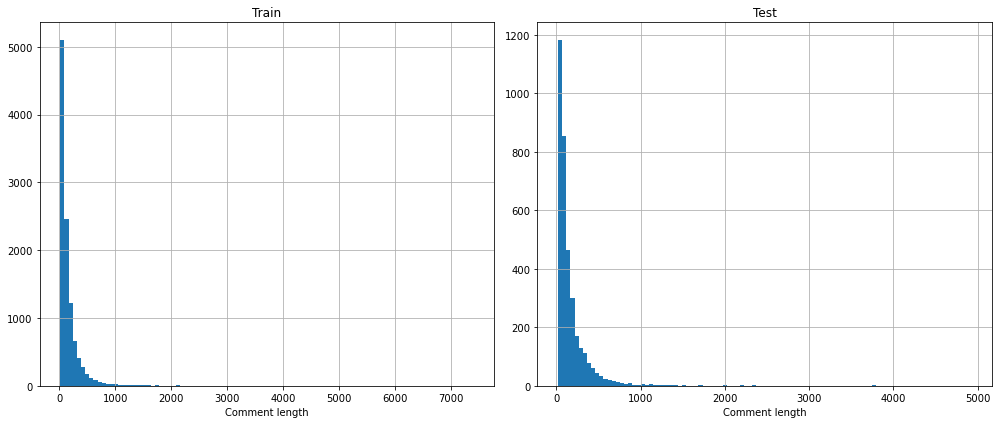

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
df_train['comment_len'].hist(ax=ax[0], bins=100)
ax[0].set(title='Train', xlabel='Comment length')

df_test['comment_len'].hist(ax=ax[1], bins=100)
ax[1].set(title='Test', xlabel='Comment length')

plt.tight_layout()

In [13]:
df_train['comment_len_log'] = np.log(df_train['comment_len'])
df_test['comment_len_log'] = np.log(df_test['comment_len'])

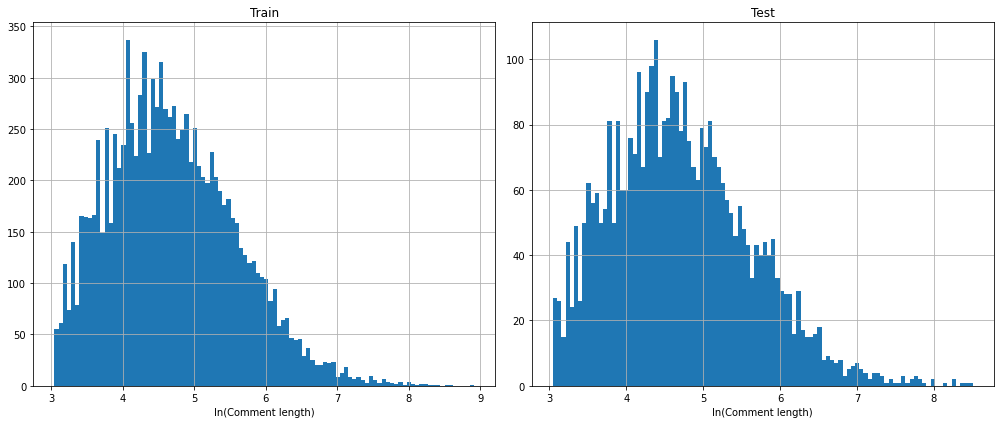

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
df_train['comment_len_log'].hist(ax=ax[0], bins=100)
ax[0].set(title='Train', xlabel='ln(Comment length)')

df_test['comment_len_log'].hist(ax=ax[1], bins=100)
ax[1].set(title='Test', xlabel='ln(Comment length)')

plt.tight_layout()

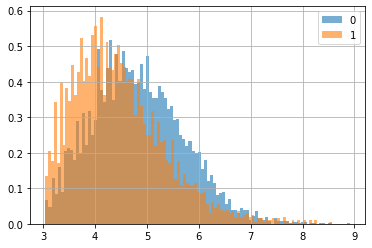

In [15]:
df_train.groupby('toxic')['comment_len_log'].hist(bins=100, alpha=0.6, density=True, legend=True);

В среднем, токсичные комментарии чуть короче нетоксичных.

## **Предобработка текстов**

In [16]:
# убираем все небуквенные символы, заменяем ё на е и делаем транслитерацию английских букв (trabslit делает это для всех букв, кроме w и q
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(re.sub('w', 'в', re.sub('q', 'кв', translit(re.sub('ё', 'e', text.lower()), 'ru'))))
    except:
        return []

In [17]:
# лемматизация
m = pymorphy2.MorphAnalyzer()

@functools.lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return re.sub('ё', 'e', pymorphy.parse(token)[0].normal_form)

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

In [19]:
def num_swear(text):
    return [lemmatize_word(w) for w in text]

In [20]:
# удаление стоп-слов и слов длины 1-2
mystopwords = stopwords.words('russian') 

def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 2]

In [21]:
mystopwords.sort()
print(*mystopwords)

а без более больше будет будто бы был была были было быть в вам вас вдруг ведь во вот впрочем все всегда всего всех всю вы где да даже два для до другой его ее ей ему если есть еще ж же за зачем здесь и из или им иногда их к как какая какой когда конечно кто куда ли лучше между меня мне много может можно мой моя мы на над надо наконец нас не него нее ней нельзя нет ни нибудь никогда ним них ничего но ну о об один он она они опять от перед по под после потом потому почти при про раз разве с сам свою себе себя сейчас со совсем так такой там тебя тем теперь то тогда того тоже только том тот три тут ты у уж уже хорошо хоть чего чем через что чтоб чтобы чуть эти этого этой этом этот эту я


In [22]:
mystopwords.remove('хорошо')

In [23]:
# дополнительный список стоп-слов
add_stopwords = pd.read_fwf('stopwords-ru.txt', header=None)
add_stopwords = add_stopwords[0].tolist()

In [24]:
mystopwords += add_stopwords
mystopwords = list(set(mystopwords))
mystopwords.sort()
print(*mystopwords)

c а б без белый более больше будем будет будете будешь будто буду будут будь бы бывает был была были было быть в вам вами вас ваш ваша ваше ваши вдали вдруг ведь везде весь вне во вокруг вон вообще восемнадцатый восемнадцать восемь восьмой вот впрочем всe все всегда всего всем всеми всему всех всею всю всюду вся второй вы г где год да давать даже два двадцатый двадцать две двенадцатый двенадцать двух девятнадцатый девятнадцать девятый девять действительно дел день десятый десять для до другая другие других другое другой е его ее ей ему если есть ещe еще ею ж же за затем зато зачем здесь значит значить и иди идти из или им именно ими имя иногда их к каждая каждое каждые каждый как какая какой кем когда кого ком кому конечно которая которого которой которые который которых кроме кто куда лет ли либо лишь лучше люди м между менее меньше меня месяц мне много мной мною мог могу могут мож может можно мои мой мочь моя моё мы на наверху над надо назад наиболее наконец нам нами нас наш наша наш

In [25]:
# функция для предобработки
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [26]:
# все шаги предобработки были записаны в файл clean_text.py - это необходимо, чтобы на Windows запустить распараллеливание
encoding='utf-8'
import clean_text
if __name__ ==  '__main__':
    num_processors = 8
    p = Pool(processes = num_processors)

    lemmas_train = list(tqdm(p.map(clean_text.clean_text, df_train['comment']), total=len(df_train)))
    lemmas_test = list(tqdm(p.map(clean_text.clean_text, df_test['comment']), total=len(df_test)))

  0%|          | 0/10809 [00:00<?, ?it/s]

  0%|          | 0/3603 [00:00<?, ?it/s]

In [27]:
# столбцы с леммами
df_train['lemmas'] = lemmas_train
df_test['lemmas'] = lemmas_test

In [28]:
df_train

,comment,toxic,comment_len,comment_len_log,lemmas
0,Преступление и наказание\n,0,25,3.218876,преступление наказание
1,"И именно эти неработающие весы показывают, что работающих нет?..\n",0,65,4.174387,неработающий весы показывать работать
2,"В Японии такие панельки, ебанько.\n",0,34,3.526361,япония панелька ебанько
3,"Еще у нас выявляют трещины с помощью белой краски и магнитной краски, потом прислоняют большой магнит и трещины проявляются. Не знаю как этот метод называется, у нас швы труб до 300мм им проверяют\n",0,197,5.283204,выявлять трещина помощь краска магнитная краска прислонять большой магнит трещина проявляться знать метод называться шов труба проверять
4,"Дочитал до поезда в Норильск , дальше не стал\n",0,46,3.828641,дочитать поезд норильск далeкий
...,...,...,...,...,...
10804,"А у мамы в группе до самого выпуска из сада такие просяки нет-нет, да случаются, с разными детьми. Только для одних детей это разовая акция, у других - время от времени, а у третьих - частенько. И родители прекрасно в курсе особенностей каждого конкретного ребенка.\n",0,266,5.583496,мама группа выпуск сад просяк случаться разный ребeнок ребeнок разовый акция время время частенько родитель прекрасно курс особенность конкретный ребeнок
10805,"Сука тупой дегенарт. Вот на эти видео. Съеби уже к своему старому куколду в жж, жухлые сморчки друг-другу теребить.\n",1,116,4.753590,сука тупой дегенарта видео съести старый куколд жухлый сморчок друг друг теребить
10806,"В племенах украинцев, особенно западных, с детства прививаются две мысли: 1. Ты самый умный. 2. Ловко наебал - значит молодец, понятия подлость и честь отсутствуют нацело. Поэтому, мой маленький дружок, вся твоя натужная изворотливость не работает. Пообщавшись с тобой пять минут, любой в России поймёт с каким сортом он имеет дело. Даже не разу не услышав мягкий акцент твоей речи.\n",1,383,5.948035,племя украинец западный детство прививаться мысль умный ловко наебал молодец понятие подлость честь отсутствовать нацело поэтому маленький дружок натужный изворотливость работать пообщаться минута любой россия понять сорт иметь дело услышать мягкий акцент речь
10807,"Пост про жадность, о том, как человек оплативший не предоставил халявы человеку предвкушающему?\n",0,96,4.564348,пост жадность оплатить предоставить халява предвкушать


**С предварительной разбивкой комментариев на предложения**

In [30]:
# разбивка текста на предложения
def sentence_list(text):
    return [_.text for _ in list(sentenize(text))]

# функция для предобработки листов предложений
def clean_sentence_text(text):
    sentences = sentence_list(text)
    tokens = [words_only(sent) for sent in sentences]
    lemmas = [lemmatize_text(tok) for tok in tokens]
    
    return [remove_stopwords(lem) for lem in lemmas]

In [36]:
#import imp
#encoding='utf-8'
#imp.reload(clean_text)
if __name__ ==  '__main__':
    num_processors = 8
    p = Pool(processes = num_processors)

    sent_lemmas_train = list(tqdm(p.map(clean_text.clean_sentence_text, df_train['comment']), total=len(df_train)))
    sent_lemmas_test = list(tqdm(p.map(clean_text.clean_sentence_text, df_test['comment']), total=len(df_test)))

  0%|          | 0/10809 [00:00<?, ?it/s]

  0%|          | 0/3603 [00:00<?, ?it/s]

In [37]:
df_train['sent_lemmas'] = sent_lemmas_train
df_test['sent_lemmas'] = sent_lemmas_test

**Частота слов в токсичных и нетоксичных комментариях**

In [28]:
words_toxic = [w for w_list in df_train[df_train['toxic']==1]['lemmas'] for w in w_list.split()]
words_nontoxic = [w for w_list in df_train[df_train['toxic']==0]['lemmas'] for w in w_list.split()]

In [29]:
len(words_toxic), len(words_nontoxic)

(43585, 109950)

In [30]:
fdist_toxic = FreqDist(words_toxic)
fdist_nontoxic = FreqDist(words_nontoxic)
fdist_all = FreqDist(words_toxic + words_nontoxic)

In [31]:
len(fdist_toxic), len(fdist_nontoxic), len(fdist_all)

(13992, 20918, 27857)

In [32]:
fdist_toxic = pd.DataFrame.from_dict(fdist_toxic, orient='index')
fdist_toxic = fdist_toxic.sort_values(0, ascending=False)
fdist_toxic.reset_index(inplace=True)

In [33]:
fdist_toxic.columns = ['lemma', 'freq']

In [34]:
fdist_nontoxic = pd.DataFrame.from_dict(fdist_nontoxic, orient='index')
fdist_nontoxic = fdist_nontoxic.sort_values(0, ascending=False)
fdist_nontoxic.reset_index(inplace=True)

In [35]:
fdist_nontoxic.columns = ['lemma', 'freq']

In [36]:
# наиболее популярные слова в токсичных комментариях
fdist_toxic.head(20)

,lemma,freq
0,русский,179
1,хороший,171
2,хохол,153
3,блядь,150
4,тред,147
5,говорить,141
6,тупой,119
7,хуй,114
8,знать,113
9,смотреть,107


In [37]:
# наиболее популярные слова в нетоксичных комментариях
fdist_nontoxic.head(20)

,lemma,freq
0,большой,465
1,хороший,448
2,время,443
3,работать,371
4,знать,365
5,деньга,323
6,делать,316
7,работа,299
8,говорить,285
9,стоить,257


In [38]:
fdist_all = pd.DataFrame.from_dict(fdist_all, orient='index')
fdist_all = fdist_all.sort_values(0, ascending=False)
fdist_all.reset_index(inplace=True)

In [39]:
fdist_all.columns = ['lemma', 'freq']

In [40]:
# наиболее популярные слова по всем комментариям
fdist_all.head(20)

,lemma,freq
0,хороший,619
1,большой,571
2,время,524
3,знать,478
4,говорить,426
5,работать,418
6,делать,417
7,деньга,374
8,смотреть,342
9,сделать,337


In [41]:
# наименее популярные слова во всех комментариях
fdist_all[fdist_all['freq'] < 5]

,lemma,freq
5667,лечь,4
5668,цом,4
5669,генератор,4
5670,комфортно,4
5671,шоколад,4
...,...,...
27852,мдф,1
27853,прижигать,1
27854,анонимность,1
27855,обменник,1


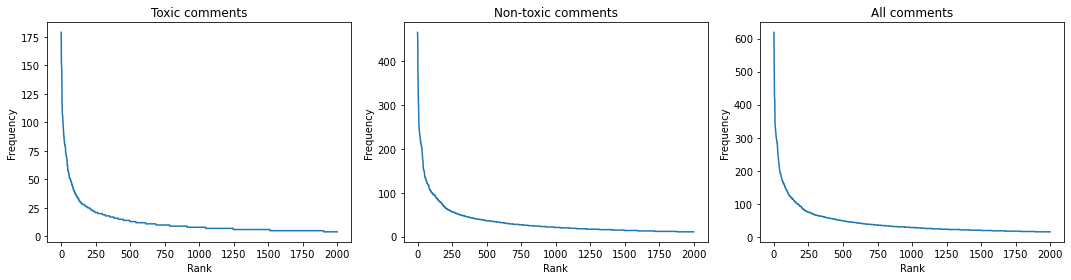

In [42]:
# Закон Ципфа

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(fdist_toxic['freq'][:2000])
ax[0].set(xlabel='Rank', ylabel='Frequency', title='Toxic comments')
ax[1].plot(fdist_nontoxic['freq'][:2000])
ax[1].set(xlabel='Rank', ylabel='Frequency', title='Non-toxic comments')
ax[2].plot(fdist_all['freq'][:2000])
ax[2].set(xlabel='Rank', ylabel='Frequency', title='All comments')

plt.tight_layout()

**Облако слов**

In [43]:
txt_toxic = ' '.join(words_toxic)
txt_nontoxic = ' '.join(words_nontoxic)

In [44]:
# параметры для облака слов
cloud_params = {
    'max_words': 200,
    'regexp': '[а-я]+',
    'collocations': False,
    
    'width': 2600,
    'height': 1200,
    'margin': 5,
    
    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,
 
    'background_color': None,
    'mode': 'RGBA',
    
    'random_state': 42
}

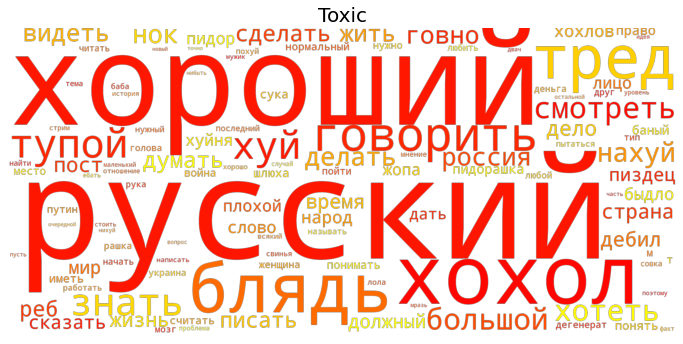

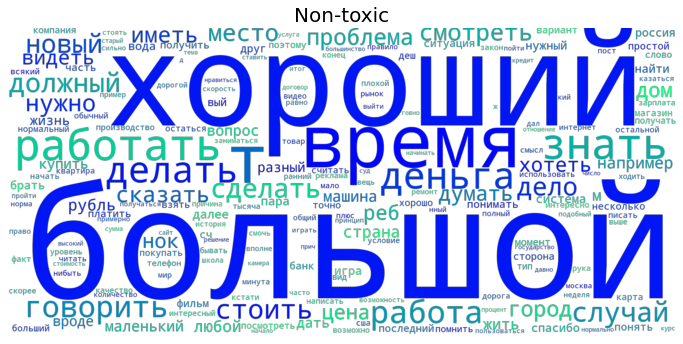

In [45]:
txts = [txt_toxic, txt_nontoxic]
cmaps = ['autumn', 'winter']
titles = ['Toxic', 'Non-toxic']

for text, cmap, title in zip(txts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear')

## **Train/ test split**

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train['len_norm'] = np.round(scaler.fit_transform(df_train[['comment_len']]),3)
df_train['len_log_norm'] = np.round(scaler.fit_transform(df_train[['comment_len_log']]),3)

In [44]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_train[['lemmas', 'sent_lemmas', 'len_norm', 'len_log_norm']], df_train['toxic'])

In [43]:
x_train.shape, x_val.shape

((8106, 3), (2703, 3))

In [50]:
grid_searcher = GridSearchCV(
    LogisticRegression(max_iter=3000, solver='liblinear', random_state=42),
    param_grid={
        'C': np.logspace(-5, 1, 6),
        'penalty': ['l1', 'l2']
    },
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5)

## **Bag of words**

In [49]:
# BoW
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train['lemmas']) 

In [51]:
grid_searcher.fit(bow, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=3000, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 1.58489319e-04, 2.51188643e-03, 3.98107171e-02,
       6.30957344e-01, 1.00000000e+01]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=5)

In [52]:
pd.DataFrame(grid_searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024733,0.003477,0.002792,0.003116,0.00001,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.669544,0.669544,0.669544,0.669544,0.669544,0.669544,0.670370,0.670370,0.670370,0.670370,0.669874,0.000405,8
1,0.031616,0.003786,0.001596,0.000798,0.00001,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.669544,0.669544,0.669544,0.669544,0.669544,0.669544,0.670370,0.670370,0.670370,0.670370,0.669874,0.000405,8
2,0.029592,0.004209,0.001450,0.000904,0.000158,l1,"{'C': 0.00015848931924611142, 'penalty': 'l1'}",0.669544,0.669544,0.669544,0.669544,0.669544,0.669544,0.670370,0.670370,0.670370,0.670370,0.669874,0.000405,8
3,0.056450,0.020116,0.001197,0.000399,0.000158,l2,"{'C': 0.00015848931924611142, 'penalty': 'l2'}",0.669544,0.669544,0.669544,0.669544,0.669544,0.669544,0.670370,0.670370,0.670370,0.670370,0.669874,0.000405,8
4,0.051961,0.014448,0.004788,0.010051,0.002512,l1,"{'C': 0.0025118864315095794, 'penalty': 'l1'}",0.669544,0.669544,0.669544,0.669544,0.669544,0.669544,0.670370,0.670370,0.670370,0.670370,0.669874,0.000405,8
5,0.075004,0.018368,0.002094,0.001695,0.002512,l2,"{'C': 0.0025118864315095794, 'penalty': 'l2'}",0.670777,0.670777,0.672010,0.669544,0.669544,0.670777,0.674074,0.672840,0.672840,0.672840,0.671602,0.001462,7
6,0.106345,0.020362,0.001297,0.000458,0.039811,l1,"{'C': 0.03981071705534969, 'penalty': 'l1'}",0.701603,0.707768,0.712700,0.701603,0.697904,0.704069,0.701235,0.711111,0.698765,0.709877,0.704664,0.005043,6
7,0.151911,0.027703,0.001496,0.000498,0.039811,l2,"{'C': 0.03981071705534969, 'penalty': 'l2'}",0.775586,0.759556,0.779285,0.764488,0.769420,0.786683,0.769136,0.765432,0.775309,0.771605,0.771650,0.007488,5
8,0.183519,0.035294,0.001497,0.000668,0.630957,l1,"{'C': 0.630957344480193, 'penalty': 'l1'}",0.828607,0.805179,0.832306,0.822441,0.821208,0.838471,0.828395,0.804938,0.834568,0.820988,0.823710,0.010801,4
9,0.406446,0.078663,0.004788,0.007722,0.630957,l2,"{'C': 0.630957344480193, 'penalty': 'l2'}",0.848335,0.822441,0.855734,0.840937,0.852035,0.864365,0.853086,0.837037,0.860494,0.854321,0.848879,0.011754,2


In [53]:
grid_searcher.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [54]:
lr = grid_searcher.best_estimator_

In [55]:
lr.fit(bow, y_train)
pred = lr.predict(vec.transform(x_val['lemmas']))
print(classification_report(pred, y_val))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1921
           1       0.70      0.83      0.76       782

    accuracy                           0.85      2703
   macro avg       0.81      0.84      0.82      2703
weighted avg       0.86      0.85      0.85      2703



**Сделаем по тесту для submission**

In [62]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(df_train['lemmas']) 

lr = LogisticRegression(max_iter=3000, random_state=42, solver='liblinear',
                       C=10, penalty='l2')
lr.fit(bow, df_train['toxic'])

pred = lr.predict(vec.transform(df_test['lemmas']))

In [63]:
submission2 = df_test[['comment_id']]
submission2['toxic'] = pred
submission2.to_csv('submission2.csv', index=False)

C:\Users\Olya\AppData\Local\Temp/ipykernel_15072/1438384169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission3['toxic'] = pred


In [64]:
df_test['toxic_bow'] = pred

## **TF-IDF**

In [57]:
def min_df_tuning(min_df_values):
    
    # словарь, в котором для каждого значения min_df указаны максимальное значением accuracy и
    # оптимальные параметры логистической регрессии
    params_score_dict = dict()
    
    for min_df in min_df_values:
        word_vectorizer = TfidfVectorizer(analyzer='word',
                                          stop_words=None,
                                          lowercase=False,
                                          token_pattern="[а-я]+",
                                          max_features=None,
                                          min_df=min_df,
                                          max_df=1.0)

        train_words = word_vectorizer.fit_transform(x_train['lemmas'])
        test_words = word_vectorizer.transform(x_val['lemmas'])

        grid_searcher.fit(train_words, y_train)
        
        params_score_dict[min_df] = (grid_searcher.best_score_, grid_searcher.best_params_)
        print(min_df)
    
    return params_score_dict

In [58]:
params_score_dict = min_df_tuning(range(0,11))

Fitting 10 folds for each of 12 candidates, totalling 120 fits
0
Fitting 10 folds for each of 12 candidates, totalling 120 fits
1
Fitting 10 folds for each of 12 candidates, totalling 120 fits
2
Fitting 10 folds for each of 12 candidates, totalling 120 fits
3
Fitting 10 folds for each of 12 candidates, totalling 120 fits
4
Fitting 10 folds for each of 12 candidates, totalling 120 fits
5
Fitting 10 folds for each of 12 candidates, totalling 120 fits
6
Fitting 10 folds for each of 12 candidates, totalling 120 fits
7
Fitting 10 folds for each of 12 candidates, totalling 120 fits
8
Fitting 10 folds for each of 12 candidates, totalling 120 fits
9
Fitting 10 folds for each of 12 candidates, totalling 120 fits
10


In [59]:
params_score_dict

{0: (0.8583760332465633, {'C': 10.0, 'penalty': 'l2'}),
 1: (0.8583760332465633, {'C': 10.0, 'penalty': 'l2'}),
 2: (0.8594868399019653, {'C': 10.0, 'penalty': 'l2'}),
 3: (0.8593633831118419, {'C': 10.0, 'penalty': 'l2'}),
 4: (0.8536900031967848, {'C': 10.0, 'penalty': 'l2'}),
 5: (0.8459178578496293, {'C': 10.0, 'penalty': 'l2'}),
 6: (0.8445612032089631, {'C': 10.0, 'penalty': 'l2'}),
 7: (0.8420945030521686, {'C': 10.0, 'penalty': 'l2'}),
 8: (0.8343235755278501, {'C': 10.0, 'penalty': 'l2'}),
 9: (0.8314862005449756, {'C': 10.0, 'penalty': 'l2'}),
 10: (0.8293906318978246, {'C': 10.0, 'penalty': 'l2'})}

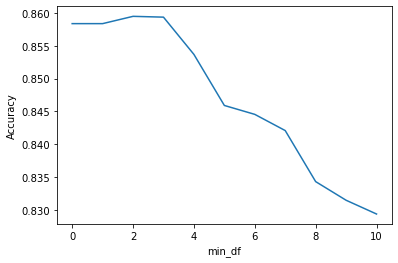

In [60]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(params_score_dict.keys(), [i[0] for i in params_score_dict.values()])
ax.set(xlabel='min_df', ylabel='Accuracy');

In [61]:
vec = TfidfVectorizer(analyzer='word',
                      stop_words=None,
                      lowercase=False,
                      token_pattern="[а-я]+",
                      max_features=None,
                      min_df=2,
                      max_df=1.0)
bow = vec.fit_transform(x_train['lemmas'])

#X = pd.DataFrame(bow.toarray(), columns = vec.get_feature_names_out())
#X['len_norm'] = df_train['len_norm']
#grid_searcher.fit(bow[:len(x_train)], y_train)

lr = LogisticRegression(max_iter=3000, random_state=42, solver='liblinear',
                       C=10, penalty='l2')
lr.fit(bow, y_train)
pred = lr.predict(vec.transform(x_val['lemmas']))
print(classification_report(pred, y_val))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1911
           1       0.71      0.83      0.77       792

    accuracy                           0.85      2703
   macro avg       0.82      0.85      0.83      2703
weighted avg       0.86      0.85      0.85      2703



In [62]:
# tf-idf для всех слов и всех текстов
feature_names = vec.get_feature_names_out()
dense = bow.todense()
denselist = dense.tolist()
densedf = pd.DataFrame(denselist, columns=feature_names)

In [64]:
# слово в тексте с максимальным tf-idf
densedf = pd.DataFrame(denselist, columns=feature_names)
densedf['max_tfidf'] = densedf.idxmax(axis=1)
densedf['toxic'] = y_train

In [65]:
# слова с максимальным tf-idf для нетоксичных комментариев
densedf[densedf['toxic']==0]['max_tfidf'].value_counts().head(30)

аааа           11
рубль           9
тред            7
хохлов          7
русский         7
реб             6
фильм           6
дом             6
спасибо         5
вероятность     5
брать           5
смотреть        5
большой         5
цена            5
доллар          5
пить            4
нравиться       4
друг            4
проблема        4
шутка           4
мозг            4
думать          4
дверь           4
даун            4
место           4
должный         4
реклама         4
быдло           4
стоить          4
город           4
Name: max_tfidf, dtype: int64

In [66]:
# слова с максимальным tf-idf для токсичных комментариев
densedf[densedf['toxic']==1]['max_tfidf'].value_counts().head(30)

фильм          10
пирамида        5
аааа            5
далее           4
цена            4
друг            4
рубль           4
сторона         4
видеть          4
хохол           4
вода            4
отзыв           3
ограничение     3
отключение      3
сдохнуть        3
бесплатный      3
тред            3
долбоеб         3
интересно       3
известный       3
оператор        3
минута          3
игра            3
часы            2
стим            2
дорогой         2
проходная       2
сука            2
ездить          2
резать          2
Name: max_tfidf, dtype: int64

In [67]:
pred_tr = lr.predict(bow)
print(classification_report(pred_tr, y_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5448
           1       0.97      0.99      0.98      2658

    accuracy                           0.99      8106
   macro avg       0.98      0.99      0.98      8106
weighted avg       0.99      0.99      0.99      8106



**Сделаем по тесту для submission**

In [62]:
vec = TfidfVectorizer(analyzer='word',
                      stop_words=None,
                      lowercase=False,
                      token_pattern="[а-я]+",
                      max_features=None,
                      min_df=2,
                      max_df=1.0)
bow = vec.fit_transform(df_train['lemmas'])

#X = pd.DataFrame(bow.toarray(), columns = vec.get_feature_names_out())
#X['len_norm'] = df_train['len_norm']
#grid_searcher.fit(bow[:len(x_train)], y_train)

lr = LogisticRegression(max_iter=3000, random_state=42, solver='liblinear',
                       C=10, penalty='l2')
lr.fit(bow, df_train['toxic'])
pred = lr.predict(vec.transform(df_test['lemmas']))

In [63]:
submission3 = df_test[['comment_id']]
submission3['toxic'] = pred
submission3.to_csv('submission3.csv', index=False)

C:\Users\Olya\AppData\Local\Temp/ipykernel_15072/1438384169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission3['toxic'] = pred


In [64]:
df_test['toxic_tfidf'] = pred

## **fastText**

См. файл part2 - его я запускала на колабе